# QUANTITATIVE TRADING STRATEGIES - HW 2

## Simple Spread Trading Strategy

**Name**: Adriana Mata

**Date**: 24/01/2024

**Table of Contents:**

1. Introduction
.

2. Data Manipulation

* 2.1. Data Extraction
* 2.2. Data Cleaning
* 2.3. Data Visualization
.

3. Simple Spread Trading Strategy
.

4. Comparative Analysis
* 4.1. FF3
* 4.2. SVOL Levels

5. Conclusions

# 1. Introduction

The Simple Spread Trading Strategy homework aims to capitalize on the price discrepancies between two assets, ETFs in this case. At its core, the strategy involves monitoring the spread - the difference in prices and returns - between these two assets, looking for opportunities where this spread diverges from its historical norm. 

The strategy enters a position when the spread widens significantly, suggesting a temporary mispricing between the two assets. This is achieved by buying the undervalued asset and short on the overvalued one, with the expectation that the spread will eventually revert to its mean, allowing for a profit on the trade. The exit strategy is carefully defined, with positions being closed when the spread narrows to a certain threshold or in response to stop-loss criteria to manage risk.

This homework involves designing and testing a Simple Spread Trading Strategy with various parameters to ultimately identify the approach that yields the highest cumulative PnL. This exercise will not only demonstrate the practical application of the strategy but also allow for a deeper understanding of its mechanics and effectiveness under different market conditions.

# 2. Data Manipulation

## 2.1. Data Extraction

The data extraction process involves retrieving financial data from NASDAQ Quandl. This extraction was done using the University of Chicago email account, which provides students with access to a wide variety of data sources and datasets for analysis.

Before starting the data extraction, it is necessary to ensure that the required libraries are imported into the Jupyter Notebook file. These libraries, such as Pandas, NumPy, Matplotlib, among others, will be very useful to reduce the length of the code and make tasks more efficient.

In [79]:
import os
import datetime
import quandl
import config

import pandas as pd
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import itertools
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings("ignore")

The ``grab_quandl_table`` function is responsible for handling the download of data tables from Quandl. This function has been designed to avoid downloading the same data repeatedly. Hence, it will only grab new data once per day; otherwise, it will use the data from the file cache.

For this function to work, we need to specify the Quandl table path, the path to the directory where we want to store the downloaded data, and the private API Key, which is provided when you create your account on Quandl. If the download is successful and there's no date override, the function creates a symlink to the downloaded file.

In [80]:
path = os.getcwd()

def grab_quandl_table(table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(path, "quandl_data_table_downloads") # Change this to your own directory
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs # Private API key
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )



This function wraps around the previously defined `grab_quandl_table` to fetch and return a Pandas DataFrame. It reads the downloaded data file into a DataFrame and returns it for further analysis.

In this case, all data regarding ‘QUOTEMEDIA/PRICES’ has been downloaded. This data contains multiple tickers, prices and volume trades for multiple dates. This data will be sorted and cleaned in the upcoming steps, as we are only focusing on two specific pairs of ETF.

In [81]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices.head()

Skipping any possible download of QUOTEMEDIA/PRICES


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.790,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.790,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.935,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.935,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.100,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.100,8.39,3086317.0
3,FLWS,2022-03-09,14.5700,14.9588,14.410,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.410,14.45,662492.0
4,RENW_,2020-01-29,21.9768,21.9900,21.970,21.99,319.0,0.0,1.0,21.9768,21.9900,21.970,21.99,319.0


This code downloads the Fama-French 3 Factor Model data from Ken French's Dartmouth website. Then, it sets the date column as the index of the DataFrame. The final result is  a DataFrame ready for time-series financial analysis with columns for 'Mkt-RF', 'SMB', 'HML', and 'RF'.

In [82]:
FF3 = pd.read_csv('http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip', skiprows=3)

FF3['date'] = pd.to_datetime(FF3['Unnamed: 0'], format='%Y%m%d')
FF3.set_index('date', inplace=True)
FF3.drop('Unnamed: 0', axis=1, inplace=True)
FF3.head()

,Mkt-RF,SMB,HML,RF
date,,,,
1990-07-02,0.69,-0.06,-0.33,0.03
1990-07-03,0.18,0.07,-0.15,0.03
1990-07-04,0.62,-0.17,-0.17,0.03
1990-07-05,-0.74,0.29,0.14,0.03
1990-07-06,0.20,-0.17,0.02,0.03


## 2.2. Data Cleaning

In this section of the project, the data will be sorted and cleaned according to the specifications provided in the **'HW2_SimpleSpreadTradingSimulation.pdf'** document.

Initially, the ETF pairs will be defined, based on the last digit of my student number, the assigned pair has been the 7th. 

* ETF Pair (X, Y):

    * X: KXI: iShares Global Consumer Staples
    * Y: XLP: Consumer staple stocks

We are also inerested in the SVOL, which represents the ETF volatility and the data will be analyzed from December 2nd of 2021 though Nov 15th of 2023.

In [83]:
SVOL = 'SVOL'

#Student ID Pair
X = 'KXI'
Y = 'XLP'

#Date Range
start_date = '2021-12-02'
end_date = '2023-11-15'

This function, `get_specific_data`, filters the data based on specific ticker codes. In this case, the tickers correspon the the Sudent ETF Pair and the SVOL level.

In [84]:
def get_specific_data(df, ticker_code):
    """ 
    Function to get specific data from the dataframe based on the ticker code

    Input:
        df (pd.DataFrame):
        ticker_code (str): ticker code of the stock

    Output:
        df (pd.DataFrame): dataframe with specific data
    """
    df = df[df['ticker'] == ticker_code]
    return df


SVOL_data = get_specific_data(prices, SVOL)
X_data = get_specific_data(prices, X)
Y_data = get_specific_data(prices, Y)

The `filter_by_date_range` function is designed to filter rows based on a specific date range, from '2021-12-02' to '2023-11-15'. This function helps narrowing down data to a targeted time period. The function processes the filtered data along with the defined time range and returns a new DataFrame encompassing only the rows that are within the specified date range.

In [85]:
def filter_by_date_range(df, start_date, end_date):
    """
    Filters a DataFrame based on a given date range.

    Inputs:
        df (pd.DataFrame): The DataFrame to be filtered.
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Outputs:
        pd.DataFrame: A filtered DataFrame containing rows within the given date range.
    """

    # Convert start and end dates to datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # Check if 'date' is a column in the DataFrame
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        filtered_df = df[(df['date'] >= start) & (df['date'] <= end)]
    else:
        # Assuming 'date' is the index
        df.index = pd.to_datetime(df.index)
        filtered_df = df[start:end]

    return filtered_df


SVOL_data = filter_by_date_range(SVOL_data, start_date, end_date)
X_data = filter_by_date_range(X_data, start_date, end_date)
Y_data = filter_by_date_range(Y_data, start_date, end_date)
FF3 = filter_by_date_range(FF3, start_date, end_date)

The `check_and_remove_nan` function is designed to handle NaN values in a given DataFrame. It first checks for the presence of any NaN values across all rows. If NaNs are found, the function reports their count and then proceeds to remove these rows from the DataFrame. If no NaNs are found, it simply reports that the dataset is clean. 

This function is applied to three different DataFrames (`SVOL_data`, `X_data`, and `Y_data`) to ensure they are free of NaN values for subsequent analysis.

In [86]:
def check_and_remove_nan(df):
    """
    Checks for NaN values in a DataFrame, reports the count, and removes them if present.

    Inputs
        df: DataFrame to be checked and processed.
    """
    # Check for rows with NaN values
    nan_count = df.isna().any(axis=1).sum()

    if nan_count > 0:
        print(f"There are {nan_count} rows with NaN values in the dataset.")
        # Remove rows with NaN values
        df.dropna(inplace=True)
        print(f"NaN values have been removed.")
    else:
        print(f"There are no NaN values in the dataset.")

check_and_remove_nan(SVOL_data)
check_and_remove_nan(X_data)
check_and_remove_nan(Y_data)

There are no NaN values in the dataset.
There are no NaN values in the dataset.
There are no NaN values in the dataset.


The function `clean_FF3_model` is designed to clean data quality issues commonly found in Fama-French model datasets. It targets the placeholder value -99.99, which is often used to represent missing or inapplicable data. After replacing -99.99 with `NaN`, the function then invokes `check_and_remove_nan`, which checks for any rows containing `NaN` values, reports the count of such rows, and removes them from the DataFrame.

In [87]:
def clean_FF3_model(df):
    """
    Cleans the input DataFrame by replacing -99.99 values with NaN and then removing rows with NaN values.

    Inputs:
        df: DataFrame to be cleaned.

    Output:
       df: The cleaned DataFrame.
    """
    df.replace(-99.99, np.nan, inplace=True)
    cleaned_df = check_and_remove_nan(df)

    return cleaned_df

clean_FF3_model(FF3)

There are no NaN values in the dataset.


The `format_and_sort_dates` function is designed to standardize and organize the date information within a DataFrame. If the DataFrame has a 'date' column, the function converts it to a datetime object with the format '%Y-%m-%d', sets this column as the DataFrame's index, and then sorts the DataFrame based on this index. If the DataFrame already has a datetime index, it ensures the index is in the correct format and sorts the DataFrame accordingly.

In [88]:
def format_and_sort_dates(df):
    """
    Checks a DataFrame for a 'date' column or index. If found, converts it to '%Y%m%d' format, sets it as the index (if not already), and sorts it.

    Inputs:
        df: The DataFrame to process.

    Output:
        df: The processed DataFrame.
    """
    
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
    
    elif pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        df.sort_index(inplace=True)
    
    else:
        print("No 'date' column or datetime index found.")

    return df

format_and_sort_dates(SVOL_data)
format_and_sort_dates(X_data)
format_and_sort_dates(Y_data)


,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2021-12-02,XLP,70.19,71.140,70.19,70.69,18701935.0,0.0,1.0,67.005219,67.912114,67.005219,67.482532,18701935.0
2021-12-03,XLP,71.08,71.680,70.87,71.57,22867131.0,0.0,1.0,67.854836,68.427612,67.654365,68.322603,22867131.0
2021-12-06,XLP,72.08,73.100,72.07,72.83,18523224.0,0.0,1.0,68.809462,69.783181,68.799916,69.525432,18523224.0
2021-12-07,XLP,72.95,73.350,72.81,72.99,13169259.0,0.0,1.0,69.639987,70.021838,69.506340,69.678172,13169259.0
2021-12-08,XLP,72.87,73.190,72.14,72.76,14489774.0,0.0,1.0,69.563617,69.869097,68.866740,69.458608,14489774.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,XLP,68.84,68.900,68.32,68.48,10336921.0,0.0,1.0,68.326930,68.386483,67.810806,67.969613,10336921.0
2023-11-10,XLP,68.64,69.025,68.27,68.96,9266222.0,0.0,1.0,68.128421,68.510551,67.761178,68.446036,9266222.0
2023-11-13,XLP,68.90,69.380,68.84,69.18,8540806.0,0.0,1.0,68.386483,68.862906,68.326930,68.664396,8540806.0


After the initial cleaning process, the next step involves aligning all DataFrames (SVOL_data, X_data, Y_data, and FF3) to ensure they share the same index for consistent analysis. This alignment is crucial because financial analyses often require comparing data points from different sources on the same date.

In [89]:
print(f'The SVOL dataframe has {SVOL_data.shape[0]} dates')
print(f'The X dataframe has {X_data.shape[0]} dates')
print(f'The Y dataframe has {Y_data.shape[0]} dates')
print(f'The FF3 dataframe has {FF3.shape[0]} dates')

The SVOL dataframe has 492 dates
The X dataframe has 492 dates
The Y dataframe has 492 dates
The FF3 dataframe has 510 dates


As it can bee seen in the printed output, the count of dates in the SVOL, X, and Y dataFrames have the same number of dates (492), however, the FF3 DataFrame contains more dates (510). This discrepancy indicates that the FF3 data covers a broader period or includes additional trading days not present in the other DataFrames.

The `check_and_align_indices` function is designed to ensure that two pandas DataFrames have matching indices. It first checks if the indices of the two DataFrames are identical. If they are, the function confirms that both DataFrames already have the same dates and returns them as is. If the indices differ, the function identifies the common dates between them and aligns both DataFrames to these common dates.

In [90]:
def check_and_align_indices(df1, df2):
    """
    Checks if two DataFrames have the same indices.
    If not, aligns them by keeping only the common indices and drops the non-common rows.

    Inputs:
        df1: First DataFrame to be compared and aligned.
        df2: Second DataFrame to be compared and aligned.

    Output:
        Tuple of aligned DataFrames (df1_aligned, df2_aligned)
    """

    if df1.index.equals(df2.index):
        print("Both dataframes have the same dates.")
        return df1, df2
    else:
        # Find common indices
        common_indices = df1.index.intersection(df2.index)
        
        # Align both DataFrames to the common indices and drop non-common rows
        df1_aligned = df1.loc[common_indices]
        df2_aligned = df2.loc[common_indices]
        
        print("Dataframes have been aligned to the same dates.")
        return df1_aligned, df2_aligned


SVOL_data, X_data = check_and_align_indices(SVOL_data, X_data)
X_data, Y_data = check_and_align_indices(X_data, Y_data)
Y_data, FF3 = check_and_align_indices(Y_data, FF3)

Both dataframes have the same dates.
Both dataframes have the same dates.
Dataframes have been aligned to the same dates.


After applying the previous function, all the dataframes - SVOL, X, Y, and FF3 - have been aligned to have the same dates.

In [91]:
print(f'The SVOL dataframe has {SVOL_data.shape[0]} dates')
print(f'The X dataframe has {X_data.shape[0]} dates')
print(f'The Y dataframe has {Y_data.shape[0]} dates')
print(f'The FF3 dataframe has {FF3.shape[0]} dates')

The SVOL dataframe has 492 dates
The X dataframe has 492 dates
The Y dataframe has 492 dates
The FF3 dataframe has 492 dates


In [92]:
(X_data.index == SVOL_data.index).all() and (Y_data.index == SVOL_data.index).all() and (FF3.index == SVOL_data.index).all() and (X_data.index == Y_data.index).all() and (X_data.index == FF3.index).all() and (Y_data.index == FF3.index).all()

True

The `display_descriptive_statistics` function is designed to computes and returns a DataFrame containing a comprehensive set of descriptive statistics
for a specified column such as the mean, standard deviation and the different quantiles, among other metrics.

In [93]:
def display_descriptive_statistics(df, column_name, index_name):
    """
    Computes and returns a DataFrame containing a comprehensive set of descriptive statistics
    for a specified column in a DataFrame.

    Inputs:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): Name of the column for which statistics are calculated.
        index_name (str): Name of the index for the resulting DataFrame.

    Outputs:
        pd.DataFrame: A DataFrame containing the descriptive statistics.
    """
    statistics = {
        "Mean": df[column_name].mean(),
        "Median": df[column_name].median(),
        "Standard Deviation": df[column_name].std(),
        "Variance": df[column_name].var(),
        "Minimum": df[column_name].min(),
        "Maximum": df[column_name].max(),
        "25% Quantile": df[column_name].quantile(0.25),
        "75% Quantile": df[column_name].quantile(0.75),
        "Interquartile Range": df[column_name].quantile(0.75) - df[column_name].quantile(0.25),
        "Skewness": df[column_name].skew(),
        "Kurtosis": df[column_name].kurt()
    }

    # Convert the dictionary to a DataFrame with the specified index name
    stats_df = pd.DataFrame(statistics, index=[index_name])

    return stats_df


## 2.3 Data Visualization

In the section of data visualization, a series of plots have been created to visualize the data from the different dataframes. These visualizations have been computed to gain insights into the characteristics and trends within each dataset to identify patterns, anomalies, relationships between variables, and potential areas of interest for deeper analysis.

The `plot_combined` function is designed to visualize and compare two datasets through two distinct types of plots. 

The first plot features dual y-axes, allowing for the comparison of two different datasets that may have different scales or units of measurement. Each dataset is plotted against a common x-axis (date) but with its own y-axis. The second plot uses a shared y-axis to directly compare the two datasets. 

The function is applied to compare two ETFs, 'KXI' and 'XLP', providing a clear visual representation of their price movements over time.

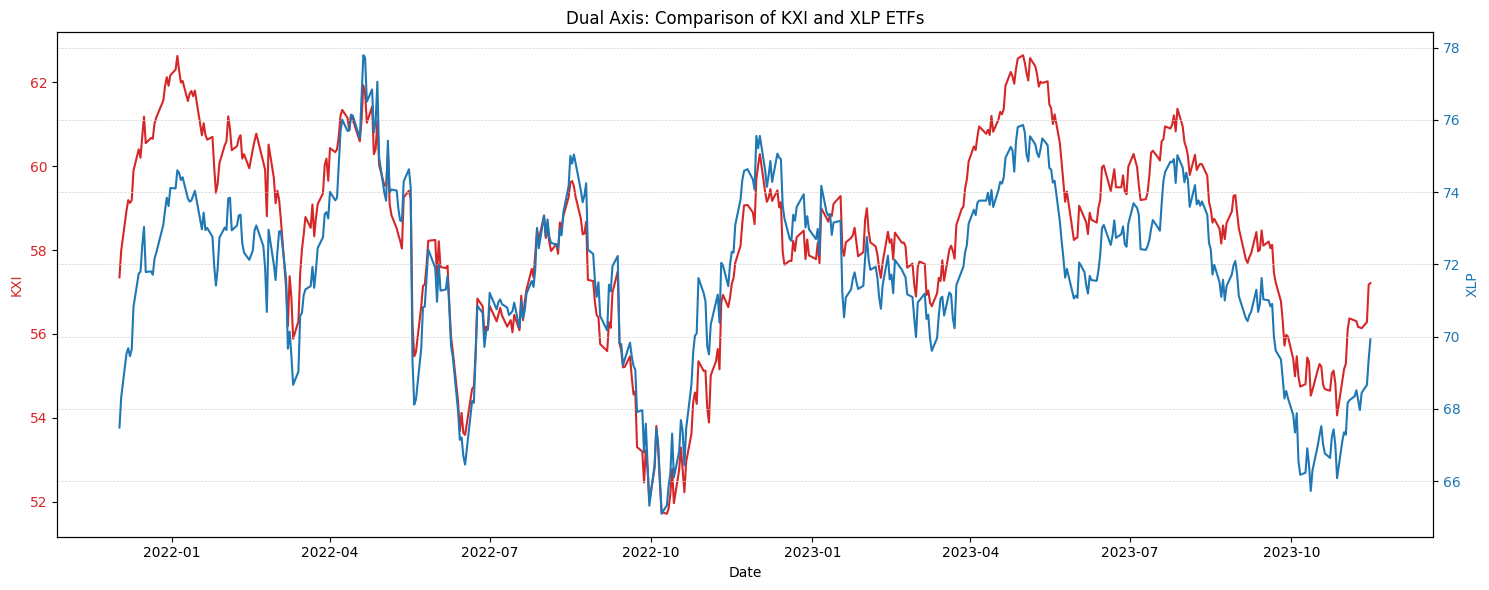

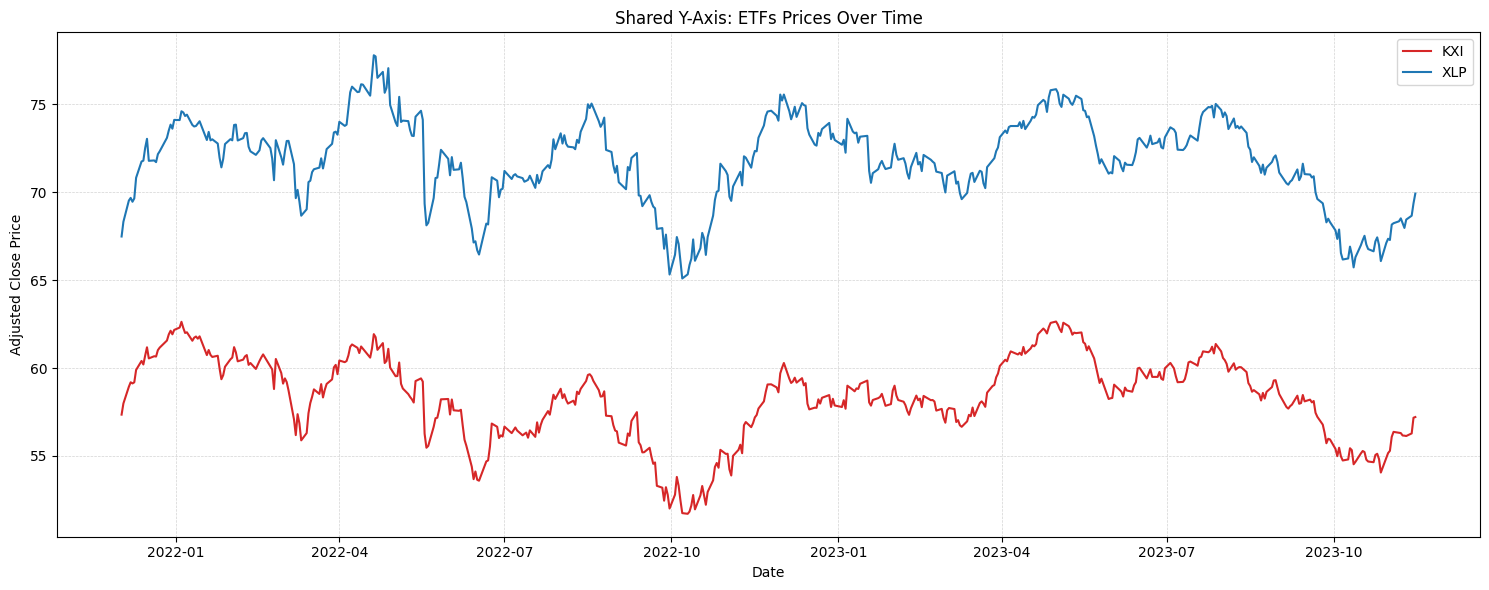

In [94]:
def plot_combined(data1, data2, label1, label2, title1, title2):
    """
    Display two types of plots: one with dual y-axes and another with a shared y-axis.

    Inputs:
        data1: DataFrame of the first dataset (X_data).
        data2: DataFrame of the second dataset (Y_data).
        label1: Label for the first dataset.
        label2: Label for the second dataset.
        title1: Title for the dual axis plot.
        title2: Title for the shared y-axis plot.

    """

    # Plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(15, 6))
    color1 = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(label1, color=color1)
    ax1.plot(data1.index, data1['adj_close'], label=label1, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel(label2, color=color2)
    ax2.plot(data2.index, data2['adj_close'], label=label2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    plt.title(title1)
    fig.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()

    # Plot with shared y-axis
    plt.figure(figsize=(15, 6))
    plt.plot(data1.index, data1['adj_close'], label=label1, color= color1)
    plt.plot(data2.index, data2['adj_close'], label=label2, color= color2)
    plt.title(title2)
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()


plot_combined(X_data, Y_data, 'KXI', 'XLP', 'Dual Axis: Comparison of KXI and XLP ETFs', 'Shared Y-Axis: ETFs Prices Over Time')

In [95]:
s1_stats = display_descriptive_statistics(X_data, 'adj_close', 'X')
s2_stats = display_descriptive_statistics(Y_data, 'adj_close', 'Y')

# Combine the statistics from both DataFrames
combination_stats = pd.concat([s1_stats, s2_stats])
combination_stats

,Mean,Median,Standard Deviation,Variance,Minimum,Maximum,25% Quantile,75% Quantile,Interquartile Range,Skewness,Kurtosis
X,58.282510,58.465622,2.360678,5.572799,51.709819,62.645636,56.777542,60.060528,3.282987,-0.501904,-0.147988
Y,71.798774,71.964181,2.462941,6.066077,65.094350,77.791768,70.596983,73.591775,2.994792,-0.504752,-0.107691


The first graph "Dual Axis: Comparison of KXI and XLP ETFs" displays the adjusted close prices for two ETFs plotted over time on the same x-axis, however each represented on a separate y-axis to accommodate the different price ranges of KXI and XLP. This dual-axis format allows for a clear comparison of price movements relative to each other, despite their differing scales. The graph suggests a positive correlation in their behaviors, indicating that the ETFs may respond similarly to market changes, though not necessarily with the same magnitude.

The second graph, "Shared Y-Axis: ETFs Prices Over Time" displays the adjusted close prices for two ETFs plotted over time on the same y-axis, emphasizing the direct comparison of their price levels. The blue line representing XLP consistently registers higher prices than the red line for KXI, which is confirmed by the statistical metrics. These metrics reveal that XLP's mean and median prices are higher than those of KXI, indicative of its overall higher pricing structure during the observed period. 

The `plot_dataset` function is designed to visualize one datasets. This function has been used to plot the SVOL levels and the Fama-French 3 model.

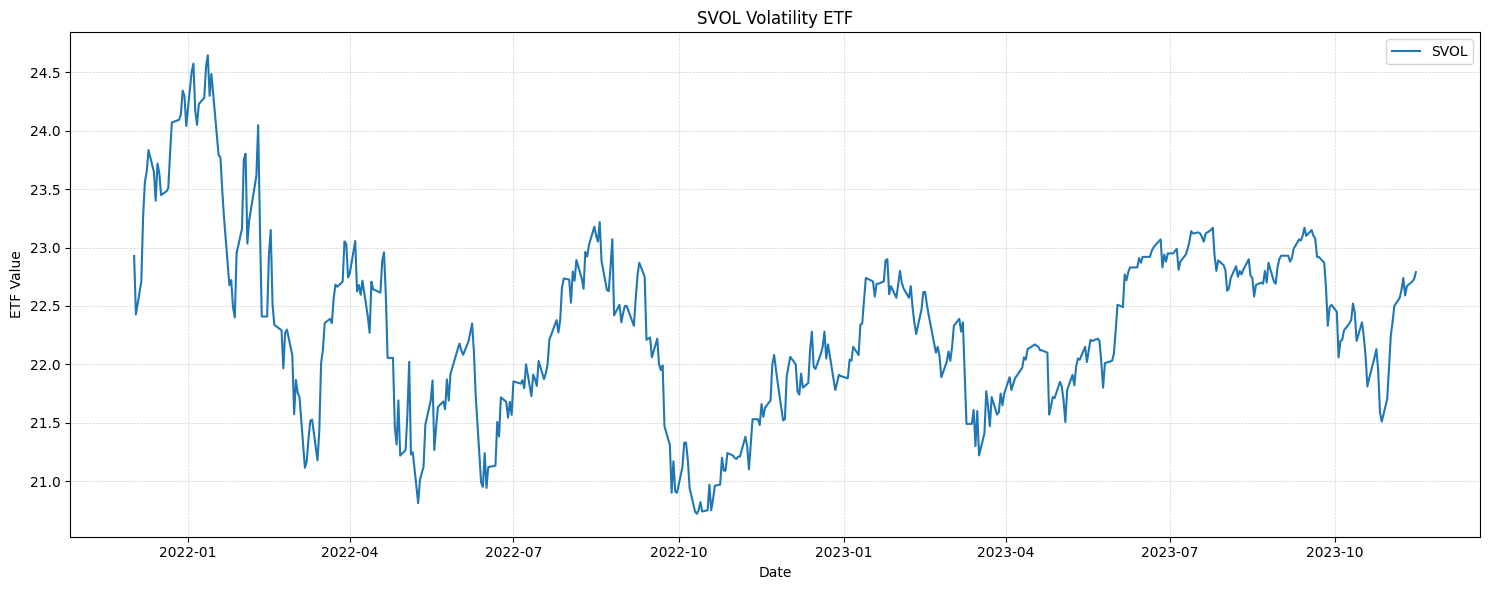

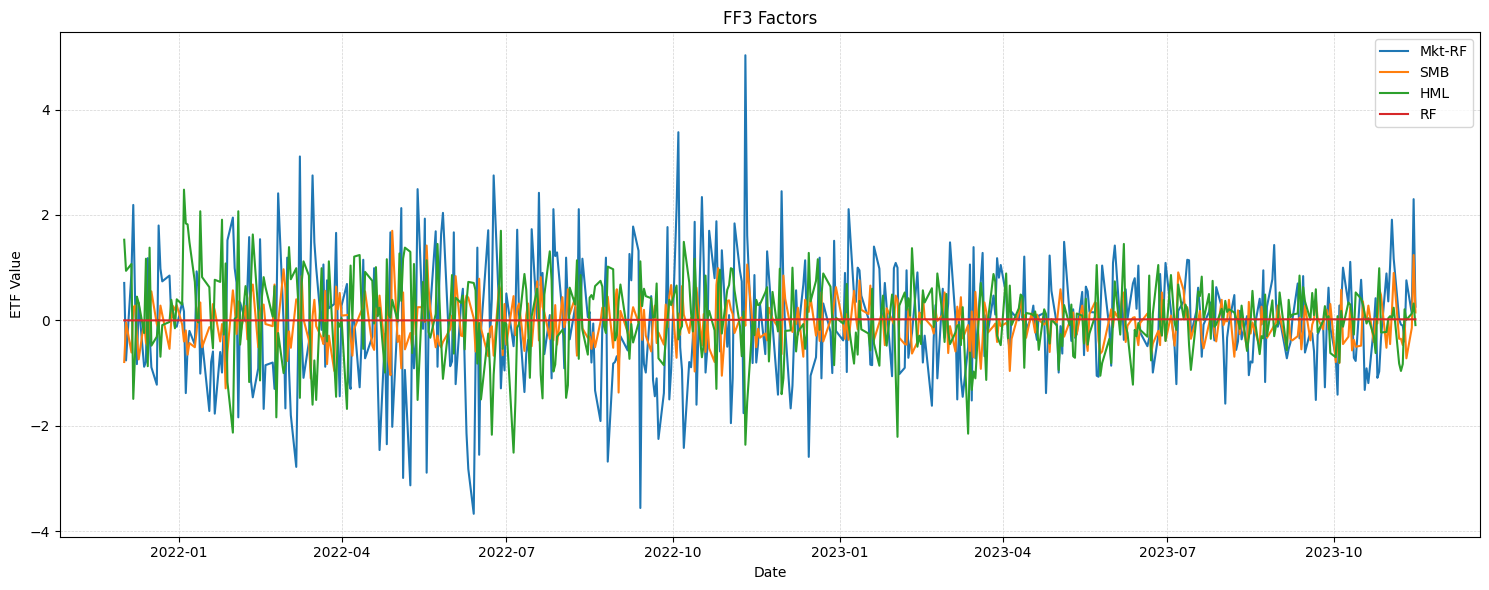

In [96]:
def plot_dataset(data, label, column_name, title, xlabel='Date', ylabel='ETF Value'):
    """
    Plot a single dataset.

    Inputs:
        data: DataFrame of the dataset.
        label: Label for the dataset.
        title: Title of the plot.
        xlabel: Label for the X-axis.
        ylabel: Label for the Y-axis.
    """
    plt.figure(figsize=(15, 6))


    plt.plot(data.index, data[column_name], label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()


plot_dataset(SVOL_data, 'SVOL', 'adj_close', 'SVOL Volatility ETF')
plot_dataset(FF3, ['Mkt-RF', 'SMB', 'HML', 'RF'], ['Mkt-RF', 'SMB', 'HML', 'RF'], 'FF3 Factors')


In [97]:
display_descriptive_statistics(SVOL_data, 'adj_close', 'SVOL')

,Mean,Median,Standard Deviation,Variance,Minimum,Maximum,25% Quantile,75% Quantile,Interquartile Range,Skewness,Kurtosis
SVOL,22.316787,22.285,0.754664,0.569518,20.72,24.646841,21.81,22.8,0.99,0.336228,0.263737


The two graphs illustrate distinct aspects of market dynamics, the first graph focusing on the volatility levels (SVOL) and the second graph, focusing on the Fama-French 3 model factors. 

In the "SVOL Volatility ETF" graph, the SVOL data exhibits notable fluctuations. The data points cluster around the mean value of 22.32, and the standard deviation of 0.75 indicates that most data points lie within this range from the mean, providing a sense of the volatility's intensity and stability over the timeframe examined.

The "FF3 Factors" graph presents a comparative visualization of the Fama-French three factors – Market Risk Premium (Mkt-RF), Size Premium (SMB), and Value Premium (HML) – alongside the risk-free rate (RF). The Market factor demonstrates the most pronounced volatility, with broader swings, implying that overall market movements contribute significantly to investment risk and return. The HML, or Value factor, also shows variability, indicating that the difference between the returns of high book-to-market stocks and low book-to-market stocks can also influence investment performance. The SMB, or Size factor, exhibits the least volatility, suggesting that the size effect – the performance differential between small-cap and large-cap stocks – is less pronounced. Lastly, the risk-free rate remains relatively constant over time, as expected for a stable benchmark rate.


# 3. Simple Spread Trading Strategy

In this section of the project, we will concentrate on developing a Simple Spread Trading. This strategy will be developed through a series of systematic steps that contribute to the generation of trade signals, position management, risk control, and the incorporation of trading costs and capital considerations. 

The strategy begins with implementing positions based on specific criteria derived from market analysis. Next, we'll perform mark-to-market valuation to assess the current value of our holdings. A stop-loss mechanism will be integrated to manage risk and limit potential losses. Additionally, there is a process to close positions at the end of the data period to crystallize gains or losses.

The first function `estimate_daily_dollar_volume`, is designed to calcualte the daily dollar trading volume of an ETF by multiplying the adjusted close price by the adjusted trading volume. 

Then, the `estimate_running_median` function computes the rolling median of this daily dollar volume over a specified window, typically 15 trading days, to smooth out short-term fluctuations and provide a more stable estimate of trading volume. 

Lastly, `compute_Nt` uses these calculations to determine the number of shares to trade for a pair of ETFs. It compares the liquidity of the two ETFs based on their running median dollar volumes and identifies the less liquid one, which guides how many shares to buy or sell. If the running medians overlap, it indicates that the less liquid ETF cannot be determined using this method.

$$N_t := Median[{V_{t−16},V_{t−15},...,V_{t−1}}]$$

In [98]:
def estimate_daily_dollar_volume(data):
    """
    Estimate daily dollar volume of an ETF.

    Inputs:
        data: pd.DataFrame containing 'adj_close' and 'volume' columns.
    
    Outputs:
        A Series representing the daily dollar volume.
    """
    return data['adj_close'] * data['adj_volume']


def estimate_running_median(data, window=15):
    """
    Compute the running trailing 15-trading-day median of the daily dollar volume.

    Inputs:
        data: pd.Series containing the daily dollar volume.
        window: Size of the rolling window.
    
    Outputs:
        A Series representing the running median of the daily dollar volume.
    """
    return data.rolling(window).median().shift()


def compute_Nt(data1, data2, window=15):
    """ 
    Compute the number of shares to buy or sell of each ETF.

    Inputs:
        data1: pd.DataFrame of the first ETF.
        data2: pd.DataFrame of the second ETF.
        window: Size of the rolling window.

    Outputs:
        A Series representing the number of shares to buy or sell of each ETF.
    """    
        
    daily_dollar_vol_1 = estimate_daily_dollar_volume(data1)
    daily_dollar_vol_2 = estimate_daily_dollar_volume(data2)
        
    running_median_1 = estimate_running_median(daily_dollar_vol_1, window)
    running_median_2 = estimate_running_median(daily_dollar_vol_2, window)

    if running_median_1.min() > running_median_2.max():
        return running_median_2
    elif running_median_2.min() > running_median_1.max():
        return running_median_1
    else:
        print('The less liquid ETF cannot be determined with this method since the running medians of the ETFs are overlapping')


In [99]:
Nt = compute_Nt(X_data, Y_data).to_frame('Running medians')
Nt.tail(5)

,Running medians
date,
2023-11-09,3.097276e+06
2023-11-10,2.624383e+06
2023-11-13,2.624383e+06
2023-11-14,2.624383e+06
2023-11-15,2.624383e+06


We will start by creating a `price_data` dataframe that consolidates adjusted closing prices from three separate DataFrames — `X_data`, `Y_data`, and `SVOL_data` — into a single DataFrame for ease of analysis.

In [100]:
price_data = pd.DataFrame(index=X_data.index)
price_data['X_price'] = X_data['adj_close']
price_data['Y_price'] = Y_data['adj_close']
price_data['SVOL_price'] = SVOL_data['adj_close']

price_data

,X_price,Y_price,SVOL_price
date,,,
2021-12-02,57.350363,67.482532,22.928100
2021-12-03,57.986008,68.322603,22.426795
2021-12-06,58.934732,69.525432,22.708230
2021-12-07,59.190887,69.678172,23.262303
2021-12-08,59.124476,69.458608,23.563878
...,...,...,...
2023-11-09,56.154191,67.969613,22.590000
2023-11-10,56.134584,68.446036,22.670000
2023-11-13,56.281636,68.664396,22.710000


We will also create a `all_data` dataframe that not only consolidates adjusted closing prices from three separate DataFrames —`X_data`, `Y_data`, and `SVOL_data`— into a single DataFrame for ease of analysis but also includes the Fama-French 3 Model Factors. 

In [101]:
all_data = pd.DataFrame(index=X_data.index)
all_data['X_price'] = X_data['adj_close']
all_data['Y_price'] = Y_data['adj_close']
all_data['SVOL_price'] = SVOL_data['adj_close']

for factor in FF3.columns:
    all_data[f'{factor}'] = FF3[factor]

combined_data = all_data.reindex(X_data.index)
combined_data

,X_price,Y_price,SVOL_price,Mkt-RF,SMB,HML,RF
date,,,,,,,
2021-12-02,57.350363,67.482532,22.928100,0.71,-0.79,1.53,0.00
2021-12-03,57.986008,68.322603,22.426795,-0.76,-0.04,0.94,0.00
2021-12-06,58.934732,69.525432,22.708230,0.90,-0.61,1.07,0.00
2021-12-07,59.190887,69.678172,23.262303,2.19,0.25,-1.49,0.00
2021-12-08,59.124476,69.458608,23.563878,0.39,0.28,-0.63,0.00
...,...,...,...,...,...,...,...
2023-11-09,56.154191,67.969613,22.590000,-0.40,0.00,0.21,0.02
2023-11-10,56.134584,68.446036,22.670000,0.76,-0.72,0.01,0.02
2023-11-13,56.281636,68.664396,22.710000,0.13,-0.14,0.13,0.02


We will establish key parameters for the framework of our trades. These parameters encompass the temporal bounds of our strategy with defined start and end trading dates, dictating the period over which the strategy will be active.

The `trading_size` parameter will guide the scale of each trade, in conjunction with the `window-day return` (`M`) which helps calculate the moving metrics for triggering trades. Entry (`g`) and exit (`j`) thresholds are critical for determining when to open and close positions, acting as our strategy's signals for market entry and exit points. The `stop loss` (`s`) parameter serves as a risk management tool, setting a predefined level of loss at which a position will be exited to prevent further downside.

Furthermore, the strategy accounts for trading costs with the parameter `ζ` (zeta), which simulates real-world transaction costs and can affect trade profitability. Zeta has two possible values: zero, representing an idealized costless scenario, and 0.00001, reflecting a more realistic, minimal trading cost environment.

Lastly, the capital parameter `K` represents the total funds allocated to the strategy. Trades are executed in equal-sized dollar amounts for both assets X and Y, rounded to the nearest integer number of shares, targeting an investment amount as close as possible to `Nt/100` of each asset. This ensures that the strategy maintains balanced exposure to both assets, in line with the predefined capital allocation strategy.

In [102]:
start_trading_date = '2022-01-01'
end_trading_date = '2023-11-15' # All existing positions must be closed by this date

trading_size = (Nt / 100).loc[start_trading_date:end_trading_date]

M = 10  # M-day return
g = 0.015  # Entry threshold
j = 0.01  # Exit threshold
s = 0.05  # Stop loss threshold

trading_cost = True
stop_loss_reset = False

zeta = 0.00001 if trading_cost else 0  # Trading cost (only two values are possible: 0 or 0.00001)
K = 2 * Nt[start_trading_date:end_trading_date].max()  # Capital

Before implementing our spread trading strategy, we'll first plot the spread returns over an 'M-window' period to analyze their distribution and behavior over time. This initial visualization will help us understand the spread's trends. Additionally, we'll identify and highlight the maximum and minimum spread values along with the dates they occurred, providing valuable insights for setting our strategy's entry and exit thresholds.

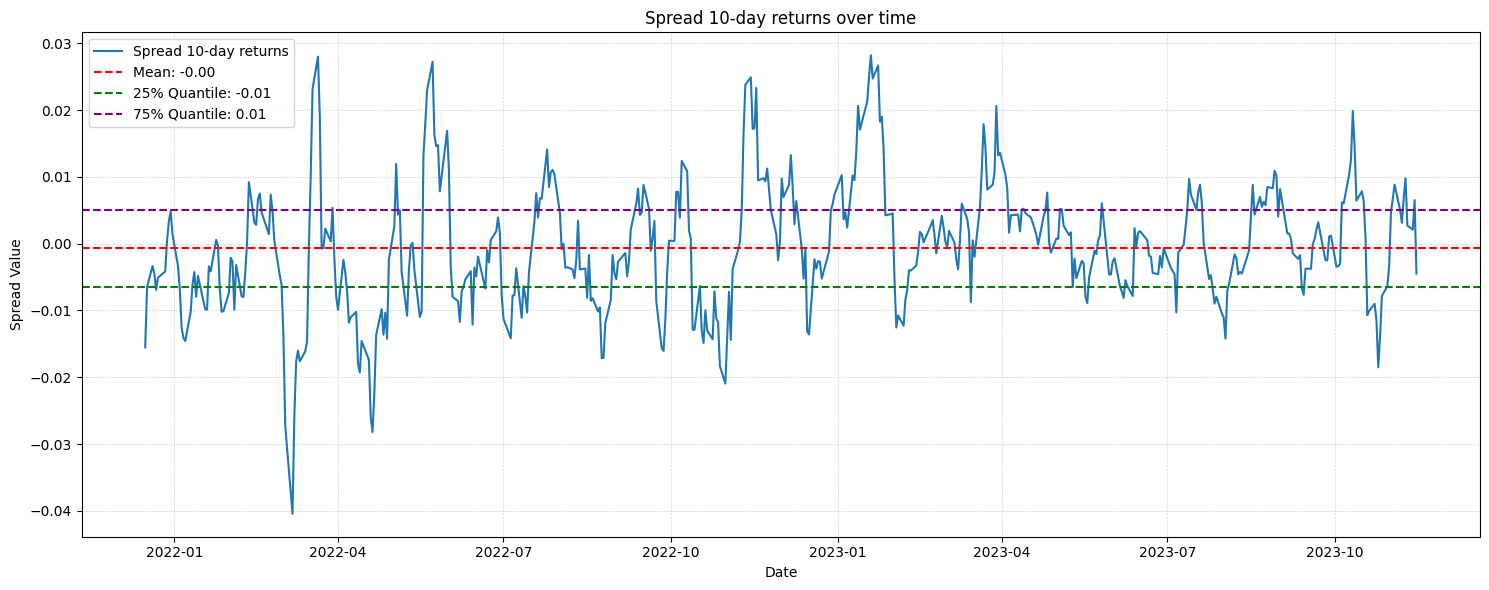

The maximum spread 10-day return is 0.02819
The date of the maximum spread 10-day return is: 2023-01-19

The minimum spread 10-day return is -0.04043
The date of the minimum spread 10-day return is: 2022-03-07


,Mean,25% Quantile,75% Quantile
Spread 10-day return,-0.00059,-0.006527,0.005021


In [103]:
price_data[f'X_return_{M}'] = price_data['X_price'].pct_change(periods=M)
price_data[f'Y_return_{M}'] = price_data['Y_price'].pct_change(periods=M)
price_data[f'XY_spread_{M}'] = price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']

spread_return_stats = display_descriptive_statistics(price_data, f'XY_spread_{M}', f'Spread {M}-day return')

mean_value = spread_return_stats['Mean']
q1_value = spread_return_stats['25% Quantile']
q3_value = spread_return_stats['75% Quantile']

summary_stats = pd.DataFrame({'Mean': mean_value,
                              '25% Quantile': q1_value,
                              '75% Quantile': q3_value})

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(price_data.index, (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']), label=f'Spread {M}-day returns')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# Plot horizontal lines for the statistics
ax.axhline(float(mean_value), color='red', linestyle='--', label=f'Mean: {float(mean_value):.2f}')
ax.axhline(float(q1_value), color='green', linestyle='--', label=f'25% Quantile: {float(q1_value):.2f}')
ax.axhline(float(q3_value), color='purple', linestyle='--', label=f'75% Quantile: {float(q3_value):.2f}')

ax.set_xlabel('Date')
ax.set_ylabel('Spread Value')
ax.set_title(f'Spread {M}-day returns over time')
ax.legend()

plt.tight_layout()
plt.show()

max_spread_return = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).max()
max_spread_return_date = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).idxmax().strftime('%Y-%m-%d')

min_spread_return = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).min()
min_spread_return_date = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).idxmin().strftime('%Y-%m-%d')

print(f'The maximum spread {M}-day return is {max_spread_return:.5f}')
print(f"The date of the maximum spread {M}-day return is: {max_spread_return_date}")
print()
print(f'The minimum spread {M}-day return is {min_spread_return:.5f}')
print(f"The date of the minimum spread {M}-day return is: {min_spread_return_date}")

summary_stats

The Simple Spread Trading strategy involvesdistinct steps aimed at capitalizing on the spread between two assets. 
The strategy's core steps include:

1. **Positions**: The strategy initiates or maintains a position when the absolute difference (`z`) in the M-day returns of assets X and Y surpasses a threshold (`g`). It exits the position if `z` falls below another threshold (`j`, where `j < g`). The strategy involves shorting the asset with the higher recent return, and it can switch between long and short positions based on significant changes in `z`.

2. **Mark To Market**: When a position is active, the strategy tracks its profit or loss (PnL) and cumulatively across all open and closed positions. This enables real-time valuation and performance assessment.

3. **Stop Loss**: A stop loss parameter (`s`) is incorporated. If a day's losses exceed a certain proportion (`s`) of the gross traded cash at position entry (`G`), the position is exited at current prices, and no new positions are opened for the rest of the month.

4. **End Of Data**: The strategy mandates closing any open position at the end of the analysis period to realize final PnL.

5. **Trading Costs**: The strategy includes a proportional trading cost parameter (`ζ`). The immediate loss on entering a trade is `ζ` times the gross traded entry position cash, and upon exit, it's `ζ` times the gross traded exit position cash.

The implementation of this strategy involves calculating the M-day returns for X and Y, managing positions, updating PnL, handling stop losses, and incorporating trading costs. The function `run_trading_strategy` executes these steps, taking parameters like start and end trading dates, trading size, entry and exit thresholds, stop loss, trading cost, and the window period for return calculation. The strategy's success hinges on effectively managing these parameters and dynamically adjusting to market conditions.

In [104]:
def run_trading_strategy(price_data, trading_size, start_trading_date, end_trading_date, j, g, s, zeta, M):
    """ 
    Trading strategy function that returns daily transactions log and cumulative PnL

    Inputs:
        price_data (pd.DataFrame): dataframe containing prices of X and Y
        trading_size (pd.DataFrame): dataframe containing trading size
        start_trading_date (str): start date of trading strategy
        end_trading_date (str): end date of trading strategy
        j (float): exit threshold
        g (float): entry threshold
        s (float): stop loss threshold
        zeta (float): trading cost
        M (int): M-day return
    
    Outputs:
        daily_transactions_log_df (pd.DataFrame): dataframe containing daily transactions log
        cumulative_pnl (float): cumulative PnL
    """
    
    # Compute M-day returns for X and Y
    price_data[f'X_return_{M}'] = price_data['X_price'].pct_change(periods=M)
    price_data[f'Y_return_{M}'] = price_data['Y_price'].pct_change(periods=M)

    
    positions = []
    daily_transactions_log = []
    cumulative_pnl = 0
    stop_loss_reset = False

    def create_position(i, current_price_X, current_price_Y, trade_size, short_X):  #create position
        X_share_size = -np.round(trade_size / current_price_X) if short_X else np.round(trade_size / current_price_X)
        Y_share_size = np.round(trade_size / current_price_Y) if short_X else -np.round(trade_size / current_price_Y)

        gross_traded_cash = abs(X_share_size * current_price_X) + abs(Y_share_size * current_price_Y)
        entry_cost = zeta * gross_traded_cash
        # entry_value = gross_traded_cash - entry_cost  # Deduct entry cost from the entry value
        entry_value = X_share_size * current_price_X + Y_share_size * current_price_Y


        position = {
            'entry_date': i,
            'entry_value': entry_value,
            'current_value': entry_value,
            'short_X': short_X,
            'X_shares': X_share_size,
            'Y_shares': Y_share_size,
            'gross_traded_cash': gross_traded_cash,
            'individual_pnl': -entry_cost  # Initial PnL is negative due to entry cost
        }
        positions.append(position)

    def update_pnl(position, current_price_X, current_price_Y):
        current_value = position['X_shares'] * current_price_X + position['Y_shares'] * current_price_Y
        last_value = position['current_value']
        position['current_value'] = current_value
        position['individual_pnl'] = current_value - last_value
        position['gross_traded_cash'] = abs(position['X_shares'] * current_price_X) + abs(position['Y_shares'] * current_price_Y)

    for i in price_data[start_trading_date:end_trading_date].index:
        
        z = abs(price_data.loc[i, f'X_return_{M}'] - price_data.loc[i, f'Y_return_{M}'])
        current_price_X, current_price_Y = price_data.loc[i, ['X_price', 'Y_price']]
        trade_size = trading_size.loc[i, 'Running medians']

        # Update and check positions
        if positions:
            update_pnl(positions[-1], current_price_X, current_price_Y)
            # Check stop loss
            position = positions[-1]
            if position['gross_traded_cash'] * s < position['entry_value'] - position['current_value']:
                exit_cost = zeta * position['gross_traded_cash']
                cumulative_pnl += position['current_value'] - position['entry_value'] - exit_cost
                positions.pop()
                stop_loss_reset = True

        # Entry logic
        if not stop_loss_reset:
            if not positions and z > g:
                create_position(i, current_price_X, current_price_Y, trade_size, price_data.loc[i, f'X_return_{M}'] > price_data.loc[i, f'Y_return_{M}'])
            elif positions and z < j:
                # Exit position
                exit_cost = zeta * positions[-1]['gross_traded_cash']
                cumulative_pnl += positions[-1]['current_value'] - positions[-1]['entry_value'] - exit_cost
                positions.pop()

        # Reset stop loss at the end of the month
        if stop_loss_reset and i.month != (i + pd.Timedelta(days=1)).month:
            stop_loss_reset = False


        current_position = positions[-1] if positions else None

        # Append current position details to daily_transactions_log
        daily_transactions_log.append({
            'date': i,
            'cumulative_pnl': cumulative_pnl,
            'entry_date': current_position['entry_date'] if current_position else None,
            'entry_value': current_position['entry_value'] if current_position else None,
            'current_value': current_position['current_value'] if current_position else None,
            'short_X': current_position['short_X'] if current_position else None,
            'X_shares': current_position['X_shares'] if current_position else None,
            'Y_shares': current_position['Y_shares'] if current_position else None,
            'gross_traded_cash': current_position['gross_traded_cash'] if current_position else None,
            'individual_pnl': current_position['individual_pnl'] if current_position else None,
        })
            

    # Close any open position at the end of the period
    if positions:
        update_pnl(positions[-1], price_data.loc[end_trading_date, 'X_price'], price_data.loc[end_trading_date, 'Y_price'])
        exit_cost = zeta * positions[-1]['gross_traded_cash']
        cumulative_pnl += positions[-1]['current_value'] - positions[-1]['entry_value'] - exit_cost
        
        # Update daily_transactions_log with the final position details
        final_position_update = {
            'date': end_trading_date,
            'cumulative_pnl': cumulative_pnl,
            'entry_date': positions[-1]['entry_date'],
            'entry_value': positions[-1]['entry_value'],
            'current_value': positions[-1]['current_value'],
            'short_X': 0,
            'X_shares': 0,
            'Y_shares': 0,
            'gross_traded_cash': 0,
            'individual_pnl': positions[-1]['current_value'] - positions[-1]['entry_value'] - exit_cost
        }
        daily_transactions_log.append(final_position_update)

        # Remove the last position as it is now closed
        positions.pop()

    daily_transactions_log_df = pd.DataFrame(daily_transactions_log).set_index('date')

    return daily_transactions_log_df, cumulative_pnl
    

To display the trades executed in the Simple Spread Strategy, the `run_trading_strategy` function returns a transaction details log with details such as entry and exit points, position sizes, and profits or losses, together with the final cumulative PnL. It's important to note that the strategy updates the cumulative PnL only upon closing positions. Therefore, the cumulative PnL shown after the last transaction accurately reflects the strategy's performance, accounting for all realized gains and losses. 

In [105]:
transaction_log, cum_pnl = run_trading_strategy(price_data, trading_size, start_trading_date, end_trading_date, j, g, s, zeta, M)
print(f"The Cumulative PnL is ${round(cum_pnl, 2)}")

# Count number of trades
non_null_count = transaction_log['current_value'].nunique()
print(f'The number of trades is {non_null_count}.')

transaction_log[transaction_log['X_shares'].notna()]

The Cumulative PnL is $2716.08
The number of trades is 63.


,cumulative_pnl,entry_date,entry_value,current_value,short_X,X_shares,Y_shares,gross_traded_cash,individual_pnl
date,,,,,,,,,
2022-03-03,0.000000,2022-03-03,-10.650677,-10.650677,False,1128.0,-916.0,133567.707668,-1.335677
2022-03-04,0.000000,2022-03-03,-10.650677,-550.303079,False,1128.0,-916.0,133045.663803,-539.652402
2022-03-07,0.000000,2022-03-03,-10.650677,-1187.865706,False,1128.0,-916.0,129978.123130,-637.562628
2022-03-08,0.000000,2022-03-03,-10.650677,-436.569508,False,1128.0,-916.0,127190.103479,751.296198
2022-03-09,0.000000,2022-03-03,-10.650677,475.392134,False,1128.0,-916.0,128964.883412,911.961642
...,...,...,...,...,...,...,...,...,...
2023-04-03,2333.503096,2023-03-29,-2.015973,-20.061799,True,-534.0,439.0,64564.095241,-24.130230
2023-10-11,2296.989552,2023-10-11,-44.524373,-44.524373,True,-731.0,608.0,80848.960424,-0.808490
2023-10-12,2296.989552,2023-10-11,-44.524373,102.582310,True,-731.0,608.0,79820.789688,147.106683


Now that the trading strategy has been developed, our goal is to optimize its performance by experimenting with different parameter values for j, g, s, ζ, and M. The objective is to identify the combination of these parameters that maximizes the cumulative Profit and Loss (PnL). Through this optimization process, we aim to fine-tune the strategy for optimal financial results.

In [106]:
j_values = [0.0025, 0.005, 0.0075, 0.01]
g_values = [0.003, 0.0075, 0.01, 0.015]
s_values = [0.01, 0.015, 0.02]
zeta_values = [0, 0.00001]
M_values = [1, 5, 10, 20, 30]

# Initialize variables to store the maximum last PnL and corresponding parameter values
max_last_pnl = float('-inf')
best_parameters = None

# Iterate over each combination
for j, g, s, zeta, M in itertools.product(j_values, g_values, s_values, zeta_values, M_values):
    transaction_log_diff, pnl = run_trading_strategy(price_data, trading_size, start_trading_date, end_trading_date, j, g, s, zeta, M)
    
    last_pnl = transaction_log_diff.iloc[-1].values[0]  # Extract the first value from the last row
    
    if last_pnl > max_last_pnl:
        max_last_pnl = last_pnl
        best_parameters = (j, g, s, zeta, M)

print(f"Maximum Last Cumulative PnL: ${round(max_last_pnl, 2)}")
print(f"Best Parameters: j={best_parameters[0]}, g={best_parameters[1]}, s={best_parameters[2]}, zeta={best_parameters[3]}, M={best_parameters[4]}")

Maximum Last Cumulative PnL: $5404.9
Best Parameters: j=0.005, g=0.003, s=0.015, zeta=0, M=20


After finding the best parameters, we will `run_trading_strategy` to retrieve the log with all the trades.

In [107]:
best_j, best_g, best_s, best_zeta, M = best_parameters

# run_trading_strategy with the best parameters
transaction_log_diff, best_pnl = run_trading_strategy(price_data, trading_size, start_trading_date, end_trading_date, best_j, best_g, best_s, best_zeta, M)

# Count the number of trades
non_null_count = transaction_log_diff['entry_date'].nunique()

print(f"The Cumulative PnL is ${round(best_pnl, 2)}")
print()
print(f"There has been a total of {non_null_count} trades")
transaction_log_diff

The Cumulative PnL is $5404.9

There has been a total of 76 trades


,cumulative_pnl,entry_date,entry_value,current_value,short_X,X_shares,Y_shares,gross_traded_cash,individual_pnl
date,,,,,,,,,
2022-01-03,0.000000,2022-01-03,30.941020,30.941020,False,462.0,-388.0,57537.038126,-0.000000
2022-01-04,0.000000,2022-01-03,30.941020,-12.119426,False,462.0,-388.0,57881.826843,-43.060446
2022-01-05,0.000000,2022-01-03,30.941020,-145.752690,False,462.0,-388.0,57695.983115,-133.633264
2022-01-06,0.000000,2022-01-03,30.941020,-200.552407,False,462.0,-388.0,57484.552005,-54.799717
2022-01-07,0.000000,2022-01-03,30.941020,-212.638236,False,462.0,-388.0,57532.135277,-12.085829
...,...,...,...,...,...,...,...,...,...
2023-11-09,5227.604594,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
2023-11-10,5227.604594,2023-11-10,56.153729,56.153729,False,468.0,-383.0,52485.817156,-0.000000
2023-11-13,5212.792845,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN


Now we will generate a plot that displays the spread returns over time for a given lookback period (M days). The black line represents the spread returns, while the blue shaded regions indicate specific trading thresholds defined by the parameters. The red dashed line at y=0 serves as a reference for zero spread. 

Additionally, the code calculates and prints the maximum and minimum spread returns during the specified period, along with their respective dates.

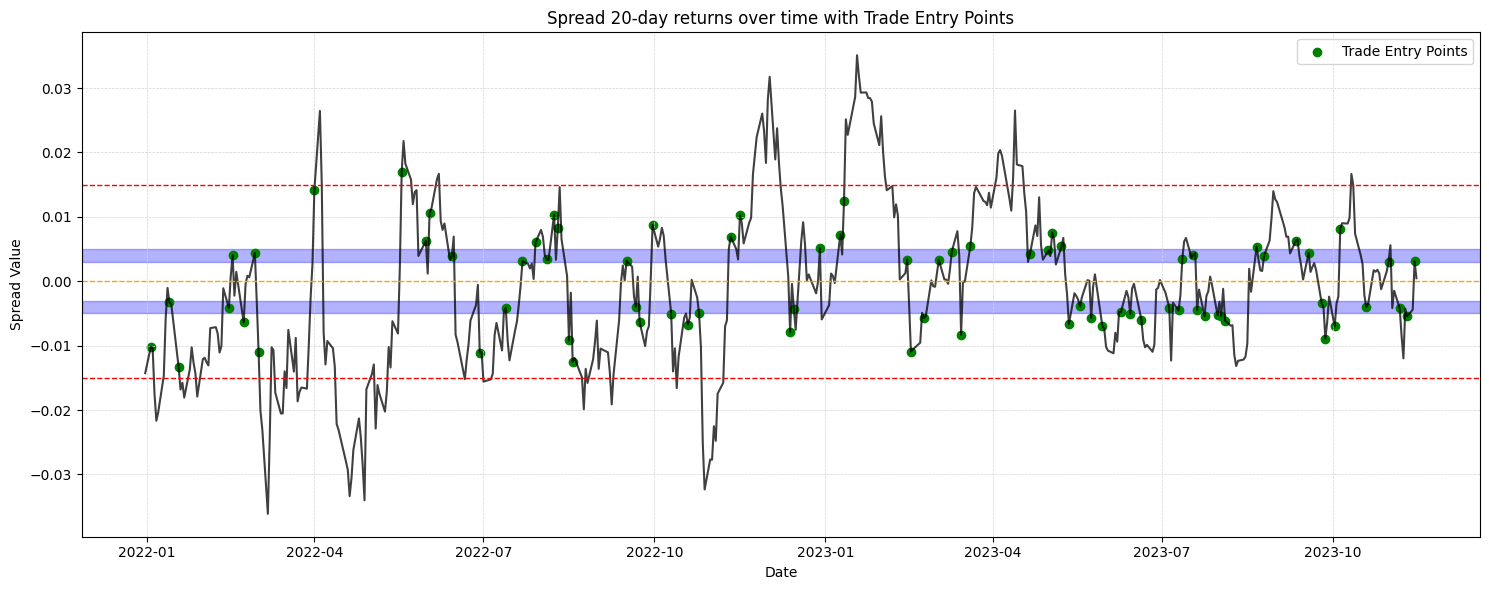

The maximum spread 20-day return is 0.03509
The date of the maximum spread 20-day return is: 2023-01-18

The minimum spread 20-day return is -0.03611
The date of the minimum spread 20-day return is: 2022-03-07


In [108]:
transaction_log_diff_noNaN = transaction_log_diff.copy()
transaction_log_diff_noNaN = transaction_log_diff_noNaN.dropna(subset=['entry_date'])

unique_entry_dates = transaction_log_diff_noNaN['entry_date'].unique()

entry_date_indices = [price_data.index.get_loc(date) for date in unique_entry_dates]

# Create a plot of the spread returns over time
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(price_data.index, (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']), color='black',alpha = 0.75)

ax.axhspan(best_j, best_g, color='blue', alpha=0.3)
ax.axhspan(-best_j, -best_g, color='blue', alpha=0.3)

ax.axhline(y=0, color='orange', linestyle='--', linewidth=1)
ax.axhline(y=best_s, color='red', linestyle='--', linewidth=1)
ax.axhline(y=-best_s, color='red', linestyle='--', linewidth=1)

# Create scatter points at the entry date indices
entry_date_values = [price_data[f'X_return_{M}'].iloc[i] - price_data[f'Y_return_{M}'].iloc[i] for i in entry_date_indices]
ax.scatter(unique_entry_dates, entry_date_values, color='green', marker='o', label='Trade Entry Points')

ax.set_title(f'Spread {M}-day returns over time with Trade Entry Points')
ax.set_xlabel('Date')
ax.set_ylabel('Spread Value')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
ax.legend()

plt.tight_layout()
plt.show()

# Plot information
max_spread_return = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).max()
max_spread_return_date = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).idxmax().strftime('%Y-%m-%d')

min_spread_return = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).min()
min_spread_return_date = (price_data[f'X_return_{M}'] - price_data[f'Y_return_{M}']).idxmin().strftime('%Y-%m-%d')

print(f'The maximum spread {M}-day return is {max_spread_return:.5f}')
print(f"The date of the maximum spread {M}-day return is: {max_spread_return_date}")
print()
print(f'The minimum spread {M}-day return is {min_spread_return:.5f}')
print(f"The date of the minimum spread {M}-day return is: {min_spread_return_date}")


In the "Spread M-day returns over time" graph, it's evident that the spread values fluctuate between positive and negative numbers throughout the entire study date range.

The shaded region on the graph serves as a visual representation of the entry and exit thresholds for trading. Specifically, we are permitted to trade when the spread values are outside this shaded area. However, trading is restricted when the spread falls within this region. 

The orange line represents the zero x-axis, indicating the point of zero spread. Additionally, the red line signifies the stop loss threshold. Any positions that exceed the positive threshold or drop below the negative threshold will trigger an immediate closure. In such cases, we must wait until the following month to initiate a new trade.

Finally, the green dots represent when the trades happen. 

Now, the Cumulative PnL will be plotted to visualize the evolution of such, as well as the dates where the Biggest Gain and Loss in Cumulative PnL happens. 

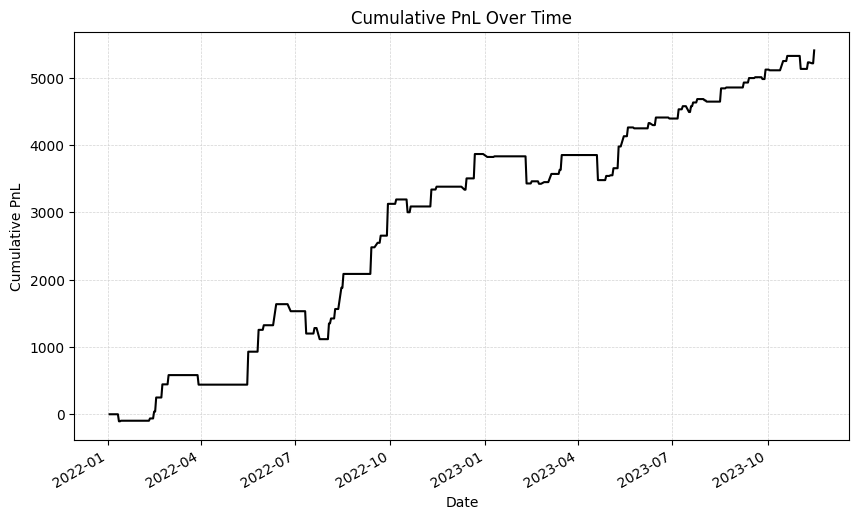

Biggest Gain in Cumulative PnL: 489.60395
The date of the biggest gain is: 2022-05-17

Biggest Loss in Cumulative PnL: -403.15581
The date of the biggest loss is: 2023-02-10


In [109]:
transaction_log_diff['cumulative_pnl'].plot(figsize=(10, 6), color='black')
plt.title("Cumulative PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

cumulative_pnl_diff = transaction_log_diff['cumulative_pnl'].diff()

# Find the biggest negative and positive differences
biggest_loss = cumulative_pnl_diff.min()
biggest_gain = cumulative_pnl_diff.max()

biggest_loss_date = (cumulative_pnl_diff).idxmin().strftime('%Y-%m-%d')
biggest_gain_date = (cumulative_pnl_diff).idxmax().strftime('%Y-%m-%d')

print(f"Biggest Gain in Cumulative PnL: {biggest_gain:.5f}")
print(f"The date of the biggest gain is: {biggest_gain_date}")
print()
print(f"Biggest Loss in Cumulative PnL: {biggest_loss:.5f}")
print(f"The date of the biggest loss is: {biggest_loss_date}")

The `find_stop_loss_spreads` function identifies instances where the spread between assets exceeds a predefined threshold. This helps in deciding when to exit positions due to high spread levels, enhancing strategy performance.

In [110]:
def find_stop_loss_spreads(price_data, transaction_log_diff, best_s):
    """ 
    Function to find the spreads that would have triggered a stop loss
    
    Inputs:
        price_data (pd.DataFrame): dataframe containing prices of X and Y
        transaction_log_diff (pd.DataFrame): dataframe containing daily transactions log
        best_s (float): stop loss threshold
    
    Outputs:
        stop_loss_df (pd.DataFrame): dataframe containing spreads that would have triggered a stop loss
    """
    # Create a copy of transaction_log_diff with NaN entries removed
    transaction_log_diff_noNaN = transaction_log_diff.copy()
    transaction_log_diff_noNaN = transaction_log_diff_noNaN.dropna(subset=['entry_date'])
    
    unique_entry_dates = transaction_log_diff_noNaN['entry_date'].unique()
    
    stop_loss_spreads = []
    
    for entry_date in unique_entry_dates:
        
        filtered_df = transaction_log_diff_noNaN[transaction_log_diff_noNaN['entry_date'] == entry_date]
        
        entry_date_index = price_data.index.get_loc(pd.to_datetime(entry_date))
        
        spread_diff = price_data[f'X_return_{M}'].iloc[entry_date_index] - price_data[f'Y_return_{M}'].iloc[entry_date_index]
        
        if spread_diff > best_s:
            stop_loss_spreads.append((entry_date, spread_diff))
    
    stop_loss_df = pd.DataFrame(stop_loss_spreads, columns=['date', 'spread_value'])
    stop_loss_df.set_index('date', inplace=True)
    
    return stop_loss_df


stop_loss_df = find_stop_loss_spreads(price_data, transaction_log_diff, best_s)
stop_loss_df

,spread_value
date,
2022-05-18,0.016976


# 4. Analysis

## 4.1. FF3

The function `calculate_strategy_returns` is designed to compute the daily returns of a trading strategy. It does this by taking the difference between the cumulative profit and loss (PnL) from one day to the next and then dividing it by the capital value, `K`. The funtions creates two new columns in the transaction log. 

In [111]:
def calculate_strategy_returns(trading_df, K):
    """ 
    Calculate the strategy returns
    
    Inputs:
        trading_df: pd.DataFrame containing the trading log
        K: Capital
    """
    K_value = K.values[0]
    trading_df[f'Net Daily PnL_{M}'] = trading_df[f'cumulative_pnl'].diff()
    trading_df[f'Strategy Returns_{M}'] = trading_df[f'Net Daily PnL_{M}'] / K_value

calculate_strategy_returns(transaction_log_diff, K)

Then, we merge the Fama-French 3 model data with the Strategy Returns just calculated into a new DataFrame.

In [112]:
combined_data = pd.merge(transaction_log_diff[f'Strategy Returns_{M}'], FF3, left_index=True, right_index=True)
combined_data.head()

,Strategy Returns_20,Mkt-RF,SMB,HML,RF
date,,,,,
2022-01-03,NaN,0.34,-0.08,0.30,0.0
2022-01-04,0.0,0.17,-0.40,2.48,0.0
2022-01-05,0.0,-1.38,-0.19,1.84,0.0
2022-01-06,0.0,-0.51,-0.65,1.82,0.0
2022-01-07,0.0,-0.20,-0.43,1.49,0.0


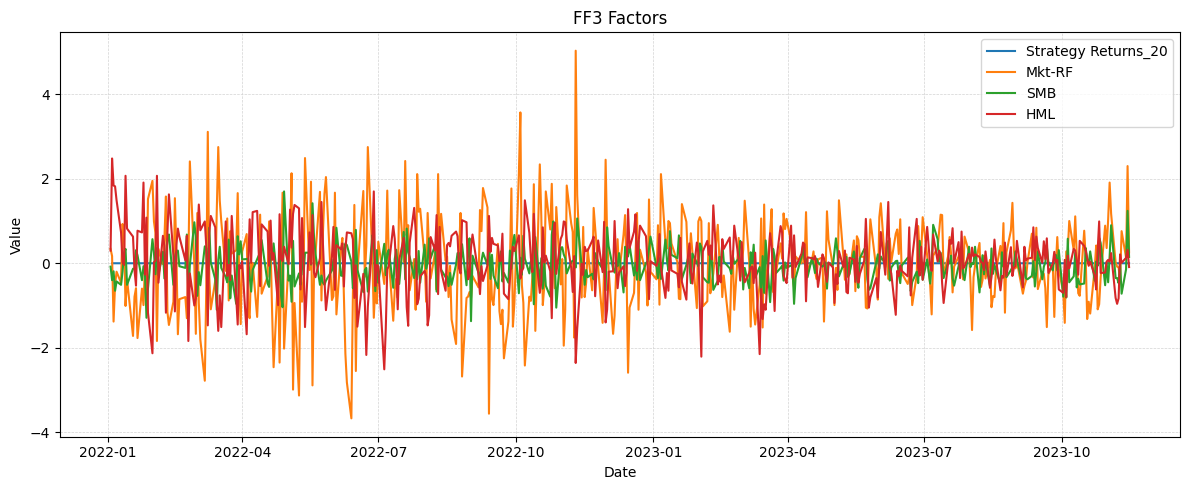

In [113]:
def plot_dataset(data, labels, column_names, title, xlabel='Date', ylabel='Value'):
    """
    Plot multiple datasets.

    Inputs:
        data: DataFrame containing the datasets.
        labels: List of labels for the datasets.
        column_names: List of column names to plot.
        title: Title of the plot.
        xlabel: Label for the X-axis.
        ylabel: Label for the Y-axis.
    """
    plt.figure(figsize=(12, 5))

    for i, col_name in enumerate(column_names):
        plt.plot(data.index, data[col_name], label=labels[i])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()

# Example usage:
plot_dataset(combined_data, [f'Strategy Returns_{M}','Mkt-RF', 'SMB', 'HML'], [f'Strategy Returns_{M}','Mkt-RF', 'SMB', 'HML'], 'FF3 Factors')


The table below indicates that the Strategy Returns have very low mean and variance. These minimal values provide limited insight into the strategy's performance dynamics.

In [114]:
display_descriptive_statistics(combined_data, f'Strategy Returns_{M}', f'Strategy Returns {M}-day').loc[:,['Mean', 'Standard Deviation', 'Variance']]

,Mean,Standard Deviation,Variance
Strategy Returns 20-day,4.718083e-07,0.000003,8.426947e-12


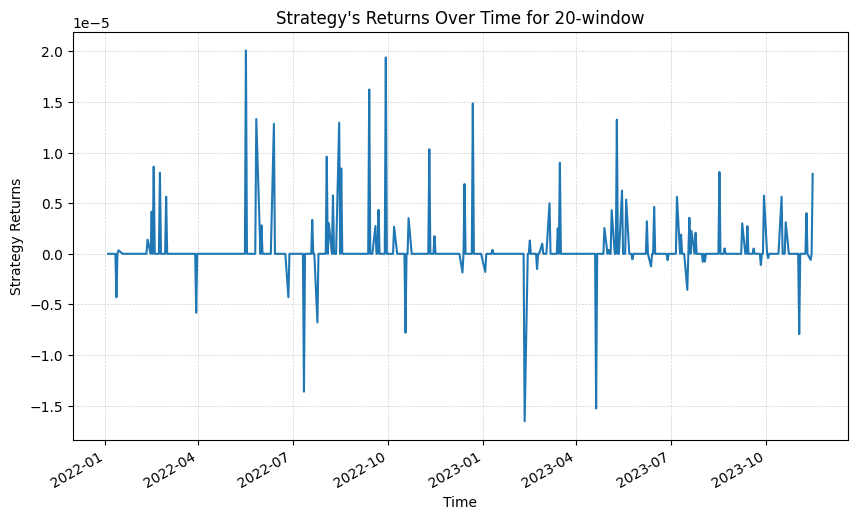

In [115]:
combined_data[f'Strategy Returns_{M}'].plot(figsize=(10, 6))
plt.title(f"Strategy's Returns Over Time for {M}-window")
plt.xlabel('Time')
plt.ylabel('Strategy Returns')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

The graph displayed above portrays the trajectory of the strategy's returns over a specified period. It is evident from the visualization that the returns predominantly hover around the zero mark. However, the graph also reveals instances of significant fluctuations on specific dates, suggesting episodes of higher strategy responsiveness. 

The `correlation_values` function is designed to compute the correlation values for a specific dataframe.

In [116]:
def correlation_values(data, column_names, title):
    """
    Compute the correlation matrix for a DataFrame.

    Inputs:
        data: DataFrame containing the datasets.
        column_names: List of column names to compute correlations.
    """
    return data[column_names].corr()


correlation_values(combined_data, [f'Strategy Returns_{M}', 'Mkt-RF', 'SMB', 'HML'], title = f'Correlation Heatmap for {M}-day Returns and FF3 Factors')

,Strategy Returns_20,Mkt-RF,SMB,HML
Strategy Returns_20,1.000000,-0.022468,0.045116,-0.054819
Mkt-RF,-0.022468,1.000000,-0.233389,-0.444565
SMB,0.045116,-0.233389,1.000000,0.015789
HML,-0.054819,-0.444565,0.015789,1.000000


These computed coefficients range from -1 to 1, where -1 indicates a perfect negative correlation, 0 indicates no correlation, and 1 indicates a perfect positive correlation.

The relationship between the Strategy Returns_20 with both Mkt-RF (-0.022468) and HML(-0.054819) are negative which implies that the strategy's returns are slightly inversely affected by overall market movements and slight tendency for the strategy's returns to decrease when high book-to-market stocks outperform low book-to-market stocks. However the relationship between the Strategy Returns_20 with the SMB has a low positive correlation which suggests that when smaller firms outperform larger firms, the strategy's returns marginally increase.

The Correlations Among Fama-French Factors range from negative values such as -0.444565 between 'Mkt-RF' and 'HML', to neutral values like 0.015789 between 'SMB' and 'HML'. 

The `sharpe_ratio` function is designed to calculate the Sharpe Ratio value for a given dataset. This function has been applied to the combined_data dataframe to extract the Sharpe Ratio on the Strategy Returns column.

In [117]:
def sharpe_ratio(df, column_name):
    """
    Calculate the Sharpe Ratio for a given dataset.

    Inputs:
        df: DataFrame containing the dataset.
        column_name: Name of the column to calculate the Sharpe Ratio.

    Outputs:
        float: The Sharpe Ratio.
    """
    # Calculate the mean and standard deviation of the returns
    mean_return = df[column_name].mean()
    std_deviation = df[column_name].std()

    # Calculate the Sharpe Ratio
    sr = mean_return / std_deviation
    return sr

SR = sharpe_ratio(combined_data, f'Strategy Returns_{M}')
print(f"The Sarpe Ratio of the Strategy is: {SR:.3f}")


The Sarpe Ratio of the Strategy is: 0.163


The Sharpe Ratio value is positive, indicating that the strategy is yielding a return above the risk-free rate. However, a Sharpe Ratio of 0.163 is relatively low which suggests that the the returns may not be significantly compensating for the level of risk incurred. This strategy, while profitable, is not highly efficient in terms of risk management.

## 4.2. SVOL Levels

In [118]:
correlation_values(price_data, ['X_price', 'Y_price', 'SVOL_price'], 'Correlation values for X, Y and SVOL')

,X_price,Y_price,SVOL_price
X_price,1.000000,0.880403,0.579028
Y_price,0.880403,1.000000,0.346522
SVOL_price,0.579028,0.346522,1.000000


The correelation between the X_price and Y_price (0.880403) is a strong positive correlation suggesting that both prices tend to move in the same direction. When the price of X increases, the price of Y also tends to increase, and vice versa. 

Secondly, the correelation between the X_price and SVOL_price (0.579028) is a moderate positive correlation implying that as the market volatility increases, the price of X also tends to increase.  

Finally, the correlation between the Y_price and SVOL_price (0.346522) is the weakest of all three. It indicates that 'Y_price' also has a tendency to increase with rising market volatility, but the relationship is less pronounced compared to 'X_price'.

The following code performs a lead-lag analysis to explore how changes in market volatility ('SVOL_price') correlate with changes in the prices of two assets ('X_price' and 'Y_price') over different time lags, specifically the analysis considers a range of lags from -5 to +5 days. Negative lags indicate that 'SVOL_price' leads the asset prices, while positive lags indicate it lags behind them.

In [119]:
lag_periods = range(-5, 6)
results = {}

for lag in lag_periods:
    df_lagged = price_data.copy()
    df_lagged['SVOL_lagged'] = df_lagged['SVOL_price'].shift(lag)
    correlation_X = df_lagged['SVOL_lagged'].corr(df_lagged['X_price'])
    correlation_Y = df_lagged['SVOL_lagged'].corr(df_lagged['Y_price'])
    results[lag] = {'Correlation_with_X': correlation_X, 'Correlation_with_Y': correlation_Y}

results_df = pd.DataFrame(results).T
results_df

,Correlation_with_X,Correlation_with_Y
-5,0.509350,0.262167
-4,0.521640,0.273546
-3,0.532049,0.283747
-2,0.546865,0.302146
-1,0.563936,0.325399
0,0.579028,0.346522
1,0.566072,0.340004
2,0.549460,0.328763
3,0.534300,0.318309
4,0.518218,0.305588


The table illustrates the correlation coefficients between 'SVOL_price' and the prices of assets X and Y across different lag values ranging from -5 to +5 days. 

The Negative Lags (-5 to -1) represent situations where 'SVOL_price' leads 'X_price' and 'Y_price' by 1 to 5 days. The correlations gradually increase as the lag gets closer to 0, suggesting that changes in market volatility are more closely related to asset prices as the time gap narrows. A stronger correlation at lags -1 and -2 indicates that market volatility today can have a more pronounced impact on asset prices in the following days.

The Lag 0 represents the contemporaneous correlation, showing how 'SVOL_price' correlates with 'X_price' and 'Y_price' on the same day. The correlation values here are the highest, indicating a strong simultaneous relationship between market volatility and asset prices.

Finally the Positive Lags (1 to 5) represent situations where 'SVOL_price' lags behind 'X_price' and 'Y_price' by 1 to 5 days. The correlations gradually decrease as the lag increases, suggesting that past asset prices have a diminishing influence on future market volatility. The decreasing trend in correlation from lag 1 to lag 5 indicates that the immediate impact of asset prices on market volatility lessens over time.

To sum up, the lagged correlation results suggest that market volatility and asset prices are interrelated, with stronger connections when the time gap between the changes in volatility and asset prices is narrower.

# 5. Conclusions

The homework effectively demonstrates the practical application of the Simple Spread Trading Strategy, focusing on exploiting price discrepancies between two ETFs. Moreover, the incorporation of a well-defined exit strategy, including stop-loss criteria, mitigates potential losses in volatile or unpredictable market conditions.

By testing various parameters,the homework explores how different settings impact the strategy's performance. This methodical testing is key to identifying the configuration that maximizes the cumulative PnL, demonstrating the importance of strategy optimization in real-world trading scenarios.

Adding further depth to the project is the comparative analysis with FF3 factors and SVOL levels. The FF3 correlation results, though generally low and occasionally negative, provide insight into the strategy's interaction with broader market factors. In contrast, the analysis of SVOL levels shows a stronger correlation with the prices of X and Y, indicating a more pronounced interplay between market volatility and spread behavior.

Overall, this homework presents a comprehensive educational experience that skillfully merges theoretical knowledge with hands-on application. It fosters a thorough understanding of the Simple Spread Trading Strategy, underscoring its intricacies and real-world relevance.